In [1]:
##########################################################
#
#   DO NOT RUN ALL CELLS. YOU ARE GUARANTEED AN ERROR!
#
##########################################################

#NOTE: If you fork this, be sure to change the filepath in the directory map

#NOTE: NOTE: You're probably only interested in the last cells

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # Clean up
# # Run this cell in order to see your changes in your Drive
# drive.flush_and_unmount()

In [4]:

import tensorflow as tf
import scipy
import scipy.ndimage as ndi
import numpy as np
import skimage
from skimage import io, filters
from skimage import data, img_as_float
import skimage.util.noise as noise
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import os
import math

import skimage
from skimage import img_as_ubyte
from skimage import exposure
from skimage import filters
from skimage import io
from skimage import color
from skimage import feature
from skimage import segmentation
from skimage import morphology
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import sobel
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.measure import label
from skimage.color import label2rgb

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


[]

In [6]:
dir_map = {
    'IMAGES_DIR':'drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images',
    'WATERSHED_DIR':'drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images/watershed',
    'SLIC_DIR' :'drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images/slic',
    'FELZ_DIR' : 'drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images/felz',
}

for _, path in dir_map.items():
    dir = os.getcwd() + '/' + path
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f'Directory "{str(dir)}" created')
    else:
        print(f'Directory "{str(dir)}" already exists')

Directory "/Users/oasis/Desktop/GeoProj/11-3-23_From Matty/GeoPoject/drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images" created
Directory "/Users/oasis/Desktop/GeoProj/11-3-23_From Matty/GeoPoject/drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images/watershed" created
Directory "/Users/oasis/Desktop/GeoProj/11-3-23_From Matty/GeoPoject/drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images/slic" created
Directory "/Users/oasis/Desktop/GeoProj/11-3-23_From Matty/GeoPoject/drive/Shareddrives/Grain Detection Project Trello/Joel/boundaries/images/felz" created


# You can ignore this

In [ ]:
# REGION BASED SEGMENTATION
#
# NOTE: looks a lot line canny, but less skeletal.... smoother. white rings at near grain boundaries
filename = "./si_ka.png"
grains = io.imread(filename)
grains_cropped = grains[100:700,:650,2]
# grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
grains_equalized = skimage.restoration.denoise_tv_chambolle(grains_cropped)
plt.imshow(grains_equalized)
elevation_map = (filters.difference_of_gaussians(grains_equalized,3) * 255).astype(np.uint8)
print(grains_cropped)
print(grains_equalized)
print(elevation_map)
#
# NOTE: looks like shit, but recall that you can densify or sparsen the number of markers
markers = np.zeros_like(grains_equalized)
markers[grains_equalized < 1] = 1
markers[grains_equalized > 250] = 2
markers = markers.astype(int)
print(markers)

#
# NOTE: Pretty decent mask. BINARY IMAGE. few holes in the problem coin (the one that remained canny in edge-based example)
segmentation_grains = segmentation.watershed(elevation_map, markers)
#
#
# NOTE: filling holes after watershed,
# NOTE: Using ndi.label on watershed binary image instead of morphology.label on local maxi dots.
#       Getting entire coins as labels instead of little dots.
# NOTE: Label RGB turns up the rainbow
segmentation_grains = ndi.binary_fill_holes(segmentation_grains - 1)
labeled_grains, _ = ndi.label(segmentation_grains)
image_label_overlay = color.label2rgb(labeled_grains, image=grains_equalized, bg_label=0)
#
#
# NOTE: The contour method puts this magical yellow ring around coins, and seems to impact image_label_overlay as well?
#       NOTE ASK GILL
fig, axes = plt.subplots(1, 2, figsize=(20, 20), sharey=True)
axes[0].imshow(grains_equalized, cmap=plt.cm.gray)
axes[0].contour(segmentation_grains, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay)
#
for a in axes:
    a.axis('off')
plt.tight_layout()
plt.show()


# SLIC Segmentation 1

In [ ]:

filename = dir_map['IMAGES_DIR'] + '/cropped_band_image.png'
# filename = dir_map['IMAGES_DIR'] + '/binary_phase_color.png'

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
print(grains_cropped.shape)
lum = color.rgb2gray(grains_equalized)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        # lum < 0.30, 500), 500)
        lum < 0.50))

mask = morphology.opening(mask, morphology.disk(3))

# NOTE: SLIC result
slic = segmentation.slic(grains_equalized,  n_segments=2000, start_label=1, max_num_iter=50, sigma=2)

# NOTE: maskSLIC result
m_slic = segmentation.slic(grains_equalized, n_segments=2000, mask=mask, start_label=1, max_num_iter=30, sigma=1)

# TODO: Dilate and erode to obtain the boundaries

# slic_combined = np.logical_and(slic, m_slic)
# slic_difference = np.logical_xor(slic, m_slic)

# seg = segmentation.mark_boundaries(grains_equalized, slic)
# print(seg.shape, seg.dtype)

# grains_marked = (segmentation.mark_boundaries(grains_equalized, slic, color=(0,0,0), outline_color=(1,0,0))* 255).astype(np.uint8)
# grains_marked = (segmentation.mark_boundaries(grains_equalized, slic)* 255).astype(np.uint8)
# grains_contours = skimage.measure.find_contours(color.rgb2gray(grains_marked, mask=mask)
# grains_mask_marked = (segmentation.mark_boundaries(grains_equalized, m_slic) * 255).astype(np.uint8)

# NOTE: Save images
# io.imsave(dir_map['SLIC_DIR'] + '/slic_combined.png', slic_combined)
# io.imsave(dir_map['SLIC_DIR'] + '/slic_difference.png', slic_difference)
# io.imsave(dir_map['SLIC_DIR'] + '/phase_color_si_marked_thresh_01.png', grains_marked)
# io.imsave(dir_map['SLIC_DIR'] + '/band_contrast_slic_equalized_small.png', grains_marked)
# io.imsave(dir_map['SLIC_DIR'] + '/band_contrast_slic_equalized_contours.png', grains_contours)
# io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_slick_eqaulized_mask.png', grains_mask_marked)

# NOTE: Display result
# fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 20))
# ax1, ax2, ax3, ax4 = ax_arr.ravel()

# ax1.imshow(grains_equalized)
# ax1.set_title('Original image')

# ax2.imshow(mask, cmap='gray')
# ax2.set_title('Mask')
fig, ax = plt.subplots(figsize=(256,256))
ax.imshow(segmentation.mark_boundaries(grains_equalized, slic))
ax.contour(mask, colors='red', linewidths=0.5)
ax.set_title('SLIC')
fig.savefig(dir_map['SLIC_DIR'] + '/band_contrast_slic_contours.png', bbox_inches='tight')

# ax4.imshow(segmentation.mark_boundaries(grains_equalized, m_slic))
# ax4.contour(mask, colors='red', linewidths=0.5)
# ax4.set_title('maskSLIC')
# plt.savefig(dir_map['SLIC_DIR'] + '/band_contrast_slic_contours.png', bbox_inches='tight')

# for ax in ax_arr.ravel():
    # ax.set_axis_off()

# plt.tight_layout()
plt.show()

# SLIC Segmentation 2

In [ ]:

# filename = "./si_ka.png"
# filename = "./11CSR01-p-(Si).bmp"
filename = './cropped_band_image.png'

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
print(grains_equalized.shape)

for label, low in enumerate(range(0.1, 1, 0.5)):
    lum = color.rgb2gray(grains_equalized)
    mask = morphology.remove_small_holes(
            morphology.remove_small_objects(
                lum < 0.30, 500), 500)
                lum < 0.37, 500), 500)

        mask = morphology.opening(mask, morphology.disk(3))

        # NOTE: SLIC result
        slic = segmentation.slic(grains_equalized,  n_segments=2000, start_label=1, max_num_iter=30, sigma=2)

        # NOTE: maskSLIC result
        m_ slic = segmentation.slic(grains_equalized, n_segments=2000, mask=mask, start_label=1, max_num_iter=30, sigma=1)

        seg = segmentation.mark_boundaries(grains_equalized, slic)
        print(seg.shape, seg.dtype)

        grains_marked = (segmentation.mark_boundaries(grains_equalized, slic)* 255).astype(np.uint8)
        grains_mask_marked = (segmentation.mark_boundaries(grains_equalized, m_slic) * 255).astype(np.uint8)

        # NOTE: Save images
        io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_equalized.png', grains_equalized)
        io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_slic_equalized.png', grains_marked)
        io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_slick_eqaulized_mask.png', grains_mask_marked)

# NOTE: Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(grains_equalized)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(grains_equalized, slic))
ax3.contour(mask, colors='red', linewidths=0.5)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(grains_equalized, m_slic))
ax4.contour(mask, colors='red', linewidths=0.5)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Edge Detection (Canny)

In [ ]:
from skimage import data, io, segmentation, color
from skimage import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


# filename = "./si_ka.png"
# filename = "./11CSR01-p-(Si).bmp"
filename = './cropped_band_image.png'

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)

# NOTE: This can cleant the image some, but doesn't really help.
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
print(grains_equalized.shape)

labels = segmentation.slic(grains_equalized, compactness=30, n_segments=400, start_label=1)
g = graph.rag_mean_color(grains_equalized, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=50, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

out = color.label2rgb(labels2, grains_equalized, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
# NOTE: Save images
# io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_canny_equalized.png', canny_grains)

# NOTE: Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(grains_equalized)
ax1.set_title('Original image')

ax2.imshow(out)
ax2.set_title('Output Image')

ax3.imshow(labels)
ax3.set_title('Labels')

ax4.imshow(out)
ax4.set_title('Labels2')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Watershed Segmentation

In [ ]:

# filename = "./si_ka.png"
# filename = "./11CSR01-p-(Si).bmp"
filename = './cropped_band_image.png'
# filename = './euler_phase.png'

grains = io.imread(filename)
grains_cropped = grains[:,:,:3]
# grains_cropped = grains[:650,:650,:3]
print(grains_cropped.shape)
# grains_cropped = grains[:650,:650,:]
# print(grains_cropped.dtype)

# NOTE: This does not work all that well, but try if you want
# restored = np.empty_like(grains_cropped)
# restored = grains_cropped
# for i in range(restored.shape[2]):
    # restored[:,:,i]= skimage.restoration.denoise_tv_chambolle(grains_cropped[:,:,i])

# grains_equalized = (skimage.exposure.equalize_hist(grains_cropped) * 255).astype(np.uint8)
# print(grains_equalized.shape)

gray_grains = (color.rgb2gray(grains_cropped)* 255).astype(np.uint8)
print(gray_grains.shape, gray_grains.dtype)

elevation_map = skimage.filters.difference_of_gaussians(gray_grains, low_sigma=10)
markers = np.zeros_like(gray_grains)

# NOTE: Uncomment this section to create and save images with varying threshold values
# for label, low in enumerate(range(60, 255, 10)):
#     for label, high in enumerate(range(70, 255, 10)):
#         markers = np.zeros_like(gray_grains)
#         markers[gray_grains < low] = 1
#         markers[gray_grains > high] = 3
#         watershed_grains = segmentation.watershed(elevation_map, markers)
#         watershed_grains = ndi.label(ndi.binar y_fill_holes(watershed_grains - 1))[0]
#         labeled_grains = (skimage.measure.label(watershed_grains)* 255).astype(np.uint8)
#         labeled_overlay = (skimage.color.label2rgb(labeled_grains, image=grains_cropped, bg_label=0)* 255).astype(np.uint8)

#         # NOTE: Save images
#         io.imsave(dir_map['WATERSHED_DIR'] + '/watershed/band_contrast_labeled_{label}_thresh_lt{low}_gt{high}.png', labeled_grains)
#         io.imsave(dir_map['WATERSHED_DIR'] + '/images/watershed/band_contrast_overlay_{label}_thresh_lt{low}_gt{high}.png', labeled_overlay)

# NOTE: Create and display a single image transformation
markers[gray_grains < 70] = 1
markers[gray_grains > 120] = 2
watershed_grains = segmentation.watershed(elevation_map, markers)
watershed_grains = ndi.label(ndi.binary_fill_holes(watershed_grains - 1))[0]

labeled_grains = (skimage.measure.label(watershed_grains)* 255).astype(np.uint8)
labeled_overlay = (skimage.color.label2rgb(labeled_grains, image=grains_cropped, bg_label=0)* 255).astype(np.uint8)

# NOTE: Save images
# io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_watershed_equalized.png', watershed_grains)
# io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_watershed_labeled.png', labeled_grains)
# io.imsave(dir_map['IMAGES_DIR'] + '/band_contrast_watershed_overlay.png', labeled_overlay)

# NOTE: Display result
fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(grains_cropped)
ax1.set_title('Original image')

ax2.imshow(segmentation.mark_boundaries(gray_grains, watershed_grains))
ax2.set_title('Watershed')

ax3.imshow(labeled_grains)
ax3.set_title('Labeled Watershed')

ax4.imshow(labeled_overlay)
ax4.set_title('Labeled Overlay')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

  # Felzenszwalbs (Good Candidate)


In [7]:
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import label
from skimage.color import label2rgb

# filename = dir_map['IMAGES_DIR'] + '/cropped_band_image.png'
# filename = dir_map['IMAGES_DIR'] + '/band_image.png'
# filename = dir_map['IMAGES_DIR'] + '/euler_phase.png'
# filename = '/Users/oasis/Desktop/GeoProj/cropped_band_image.png'
# # Change this to create a new image file (and not overwrite an existing image)
# count = 5

# grains = io.imread(filename)
# grains = img_as_float(grains)
# grains_cropped = grains[:,:,:3]
# grains_gray = color.rgb2gray(grains_cropped)
# grains_equalized = (skimage.exposure.equalize_hist(grains_gray))

# # Perform Felzenzwalbs
# segments_fz = felzenszwalb(grains_equalized, scale=300, sigma=0.8, min_size=200)
# print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')

# fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
# ax1, ax2, ax3, ax4 = ax.ravel()
# ax1.imshow(grains_equalized, cmap='gray')
# ax1.set_title("Original")

# ax2.imshow(mark_boundaries(grains_equalized, segments_fz, color=(1,0,0)))
# ax2.set_title("Felzenszwalbs's method")

# # ax3.imshow(segments_fz, cmap='gray')
# # ax3.set_title("Felzenszwalbs's Mask")

# labeled = label(segments_fz)
# ax3.imshow(labeled, cmap='gray')
# ax3.set_title("Felzenszwalbs's Labeled")

# image_label_overlay = label2rgb(labeled, image=grains_equalized)
# ax4.imshow(image_label_overlay)
# ax4.set_title("Felzenszwalbs's Label Overlayed")

# plt.tight_layout()
# plt.show()

# # Create images with the marked boundaries with background, without background and the labeled image
# segments_fz_marked = (mark_boundaries(grains_equalized, segments_fz, color=(1,0,0))* 255).astype(np.uint8)
# segments_fz_marked_black = (mark_boundaries(np.zeros_like(grains_equalized), segments_fz, color=(1,0,0))* 255).astype(np.uint8)
# labeled_marked = (mark_boundaries(labeled, segments_fz, color=(1,0,0))* 255).astype(np.uint8)

# # Save them
# io.imsave(dir_map['IMAGES_DIR'] + f'/Felz_marked_{count}.png', segments_fz_marked)
# io.imsave(dir_map['IMAGES_DIR'] + f'/Felz_marked_black_{count}.png', segments_fz_marked_black)
# io.imsave(dir_map['IMAGES_DIR'] + f'/Felz_labeled_{count}.png', (image_label_overlay* 255).astype(np.uint8))
# io.imsave(dir_map['IMAGES_DIR'] + f'/Felz_labeled_marked_{count}.png', (labeled_marked* 255).astype(np.uint8))


In [8]:
def preprocess(image):
    image = img_as_float(image)
    if image.shape[2] > 3:
        image = image[:,:,:3]
    gimage = color.rgb2gray(image)
    return skimage.exposure.equalize_hist(gimage)

def get_felzenszwalb(image, scale=1.0, sigma=0.8, min_size=10):
    '''
        Performs Felzenszwalbs segmentation and returns the segmented mask
    '''
    return felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)

def get_labeled_and_overlayed(image, mask):
    '''
        Generates the labeled image of `image`, overlays the labeled image it
        on top of `image`, and returns both the labeled and overlayed images
    '''
    labeled = label(mask)
    overlayed = label2rgb(labeled, image=image)
    return labeled, overlayed

def get_marked_boundaries(image, mask, color='red', background=True):
    colors = {'red':(1,0,0), 'green':(0,1,0), 'blue':(0,0,1), 'yellow':(1,1,0), 'white':(1,1,1) }
    assert(colors[color] is not None)

    if not background:
        image = np.zeros_like(image)

    # Cast to [0..255] so it can be saved
    return (mark_boundaries(image, mask, color=colors[color]) * 255).astype(np.uint8)

def outline_boundaries(image, marked, color='black'):
    '''
        Returns a copy of `image` overlayed with `marked`
    '''
    print(image.shape, image.dtype, marked.shape, marked.dtype)
    assert(image.shape == marked.shape)

    colors = {'red':0, 'green':1, 'blue':2, 'black':3, 'white':4, 'yellow':5}
    assert(colors[color] is not None)

    outlined = image.copy()
    for i in range(marked.shape[0]):
        for j in range(marked.shape[1]):
            if marked[i,j,:].any() > 0:
                if color == 'black':
                    outlined[i,j,:] = 0
                elif color == 'white':
                    outlined[i,j,:] = 1
                elif color == 'yellow':
                    outlined[i,j,0:2] = 1
                else:
                    outlined[i,j,v] = 1
    return (outlined * 255).astype(np.uint8)


def segment_boundaries(image, scale, sigma, min_size, outline_color='black'):
    '''
        Segments the boundaries of an image using Felzenszwalb, marks the boundaries
        and returns the boundaries segmented onto the labeled image
    '''
    # Get the segmentation mask using Felzenszwalb
    mask = get_felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)
    # Mark boundaries of the image using the mask
    marked = get_marked_boundaries(image, mask, background=False)
    # Get the labeled image overlayed with the mask
    _, overlay = get_labeled_and_overlayed(image, mask)
    # Return the segmented, labeled overlayed image with its boundaries outlined
    return outline_boundaries(overlay, marked, outline_color)


(2028, 3523, 3) float64 (2028, 3523, 3) uint8


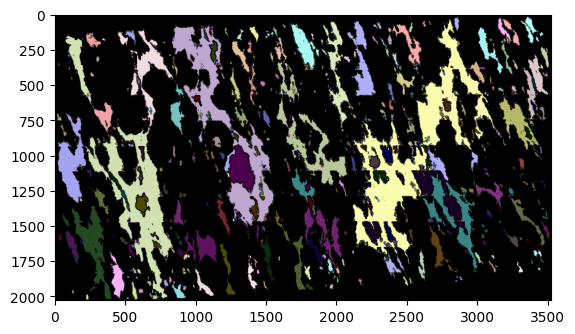

In [9]:
# filename = dir_map['IMAGES_DIR'] + '/cropped_band_image.png'
# filename = dir_map['IMAGES_DIR'] + '/band_image.png'
filename = 'Chemistry_images/SI_img4.png'
image = io.imread(filename)
# image = preprocess(image)
segmented = segment_boundaries(image, scale=300, sigma=0.8, min_size=200, outline_color='black')

plt.imshow(segmented)



In [10]:
io.imsave('felz_SI.png', segmented)